# Fraud Detection

This notebook will show how to create a model for credit card fraud detection. The data will be preprocessed and  split into train, validation and testing sets. Then the best features will be selected using sklearn and finally a model will be trained using keras to predict which transactions are fraudulent. The data came from a kaggle competition and can be found [here](https://www.kaggle.com/c/ieee-fraud-detection).

In [1]:
# using plaidml to connect to my eGPU
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
# import numpy and pandas for math and dataframe manipulation
import numpy as np
import pandas as pd

# read csv file into a pandas dataframe
train = pd.read_csv('train_transaction.csv')
test = pd.read_csv('test_transaction.csv')
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# selecting the first 55 columns because the rest seem to have many missing values
train = train.iloc[:, 0:55]
test = test.iloc[:, 0:55]
train.shape

(590540, 55)

In [4]:
# import sklearn
from sklearn.model_selection import train_test_split

# split the train dataframe into train and validation dataframes
x_train, x_val = train_test_split(train, test_size=0.2, shuffle=False)

# seperate the features and the label in the train and validation dataframes
y_train = x_train['isFraud']
y_val = x_val['isFraud']

x_train=x_train.drop(['isFraud'], axis=1)
x_val=x_val.drop(['isFraud'], axis=1)


In [5]:
# fill the null values with zeros for teh train, val and test dataframes

x_train = x_train.fillna(0)
x_val = x_val.fillna(0)

x_test = test.fillna(0)

x_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,86400,68.5,W,13926,0.0,150.0,discover,142.0,credit,...,0.0,T,T,T,M2,F,T,0,0,0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.0,0,0,0,M0,T,T,0,0,0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,315.0,T,T,T,M0,F,F,F,F,F
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,111.0,0,0,0,M0,T,F,0,0,0
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0,0,0,0,0,0,0,0,0


In [6]:
# import sklearn OneHotEncoder and category encoders to help encode categorical columns
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# use OneHotEncode on all categorical columns
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)

# fit to all three dataframes
x_train = ohe.fit_transform(x_train)
x_val = ohe.fit_transform(x_val)
x_test = ohe.fit_transform(x_test)

# make sure it worked
x_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD_W,ProductCD_H,ProductCD_C,ProductCD_S,ProductCD_R,card1,card2,...,M6_0,M7_0,M7_F,M7_T,M8_0,M8_F,M8_T,M9_0,M9_F,M9_T
0,2987000,86400,68.5,1,0,0,0,0,13926,0.0,...,0,1,0,0,1,0,0,1,0,0
1,2987001,86401,29.0,1,0,0,0,0,2755,404.0,...,0,1,0,0,1,0,0,1,0,0
2,2987002,86469,59.0,1,0,0,0,0,4663,490.0,...,0,0,1,0,0,1,0,0,1,0
3,2987003,86499,50.0,1,0,0,0,0,18132,567.0,...,0,1,0,0,1,0,0,1,0,0
4,2987004,86506,50.0,0,1,0,0,0,4497,514.0,...,1,1,0,0,1,0,0,1,0,0


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


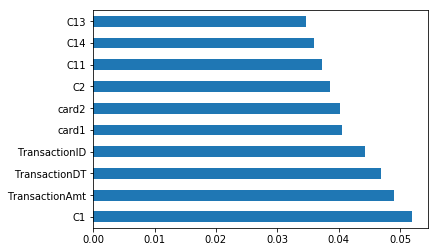

In [7]:
# import sklearn classifier and matplotlib for feature selection and plotting features
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
%matplotlib inline

# Select best features for the label
model = ExtraTreesClassifier()
model.fit(x_train, y_train)

# plot ten best features
feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [8]:
# make new dataframes with only the best features

x_train = x_train[['C1', 'TransactionAmt', 'TransactionID', 'TransactionDT', 'C2', 'card1', 'card2', 'C14', 'C11', 'C13']]

x_val = x_val[['C1', 'TransactionAmt', 'TransactionID', 'TransactionDT', 'C2', 'card1', 'card2', 'C14', 'C11', 'C13']]

x_test = x_test[['C1', 'TransactionAmt', 'TransactionID', 'TransactionDT', 'C2', 'card1', 'card2', 'C14', 'C11', 'C13']]

In [11]:
# import keras layers and optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.noise import AlphaDropout
from keras import optimizers
from keras import layers

# define keras model
model = Sequential()
model.add(Dense(64, input_dim=10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# define optimizer
opt = optimizers.Nadam(lr=.01)

# compile model
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
# fit teh model to the training set
model.fit(x_train, y_train,
          epochs=5,
          batch_size=128)
model.save_weights('first_try.h5')

Epoch 1/5
472432/472432 [==============================] - 19s 41us/step - loss: 0.5664 - acc: 0.9649
Epoch 2/5
472432/472432 [==============================] - 19s 41us/step - loss: 0.5663 - acc: 0.9649
Epoch 3/5
472432/472432 [==============================] - 19s 41us/step - loss: 0.5663 - acc: 0.9649
Epoch 4/5
472432/472432 [==============================] - 19s 41us/step - loss: 0.5663 - acc: 0.9649
Epoch 5/5
472432/472432 [==============================] - 19s 41us/step - loss: 0.5664 - acc: 0.9649


In [14]:
# use the trained model to get a validation score
score = model.evaluate(x_val, y_val, batch_size=128)

118108/118108 [==============================] - 3s 22us/step


In [15]:
# print score
score

[0.5546107083835595, 0.9655908151881195]

A this point the model trained well and the score on the validation set had the same accuracy which means the model is generalized enough to try and make predictions. 

In [17]:
# make predictions 
predictions = model.predict(x_test, batch_size=128)

In [20]:
# extract Transaction ID from dataframe
Tran_ID = x_test['TransactionID']

In [22]:
# concatenate teh predictions and the transactions ID columns together
sub = pd.DataFrame(predictions)

submissions = pd.concat([Tran_ID, sub], axis=1)

In [23]:
# print new dataframe 
submissions.head()

,TransactionID,0
0,3663549,0.0
1,3663550,0.0
2,3663551,0.0
3,3663552,0.0
4,3663553,0.0


In [24]:
# rename columns appropriately
submissions.columns = ['TransactionID', 'isFraud']
submissions.head()

,TransactionID,isFraud
0,3663549,0.0
1,3663550,0.0
2,3663551,0.0
3,3663552,0.0
4,3663553,0.0


In [29]:
# turn the dataframe into a csv file that can be downloaded and submitted
submissions.to_csv('submission.csv', sep='\t', encoding='utf-8')


In [30]:
submissions.shape

(506691, 2)